In [7]:
!pip install livelossplot

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from livelossplot.tf_keras import PlotLossesCallback
%matplotlib inline
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [9]:
np.random.seed(42)
import warnings
warnings.simplefilter('ignore')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
train_images=pd.read_csv('/content/drive/MyDrive/dataset/train/images.csv',header=None)
train_label=pd.read_csv('/content/drive/MyDrive/dataset/train/labels.csv',header=None)

val_images=pd.read_csv('/content/drive/MyDrive/dataset/validation/images.csv',header=None)
val_label=pd.read_csv('/content/drive/MyDrive/dataset/validation/labels.csv',header=None)

In [13]:
train_images.head(3)


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510


In [14]:
train_label.head(3)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0


In [15]:
train_images.shape

(3200, 8192)

In [16]:
train_label.shape

(3200, 4)

In [17]:
val_images.shape

(800, 8192)

In [18]:
val_label.shape

(800, 4)

In [19]:
x_train=train_images.values.reshape(3200,64,128,1)


In [20]:
x_val=val_images.values.reshape(800,64,128,1)

In [21]:
y_train=train_label.values
y_labels=val_label.values

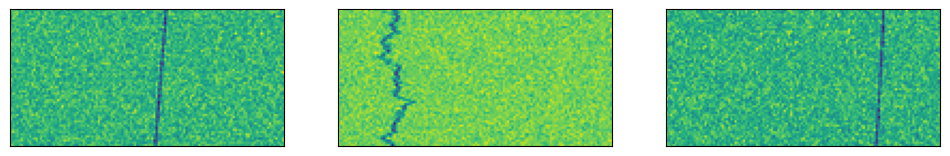

In [43]:
plt.figure(0,figsize=(12,12))
for i in range(1,4):
  plt.subplot(1,3,i)
  img=np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)

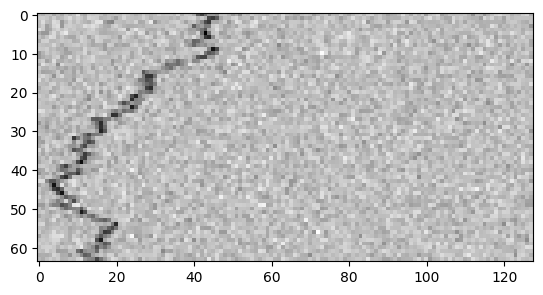

In [48]:
plt.imshow(np.squeeze(x_train[5]),cmap='gray')

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train=ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val=ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)


In [26]:
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D,Activation

In [27]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
model=Sequential()

model.add(Conv2D(32,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [29]:
model.add(Conv2D(64,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [30]:
model.add(Flatten())

In [31]:
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

In [32]:
model.add(Dense(4,activation='softmax'))

In [33]:
intial_learning_rate=0.005
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=intial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)
optimizer=Adam(learning_rate=lr_schedule)

In [34]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 128, 32)       832       
                                                                 
 batch_normalization (Batch  (None, 64, 128, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 64)        5

In [36]:
checkpoint=ModelCheckpoint(
    'model_weight.h5',monitor='val_loss',save_weights_only=True,mode='min',verbose=0
)
callbacks=[PlotLossesCallback(),checkpoint]


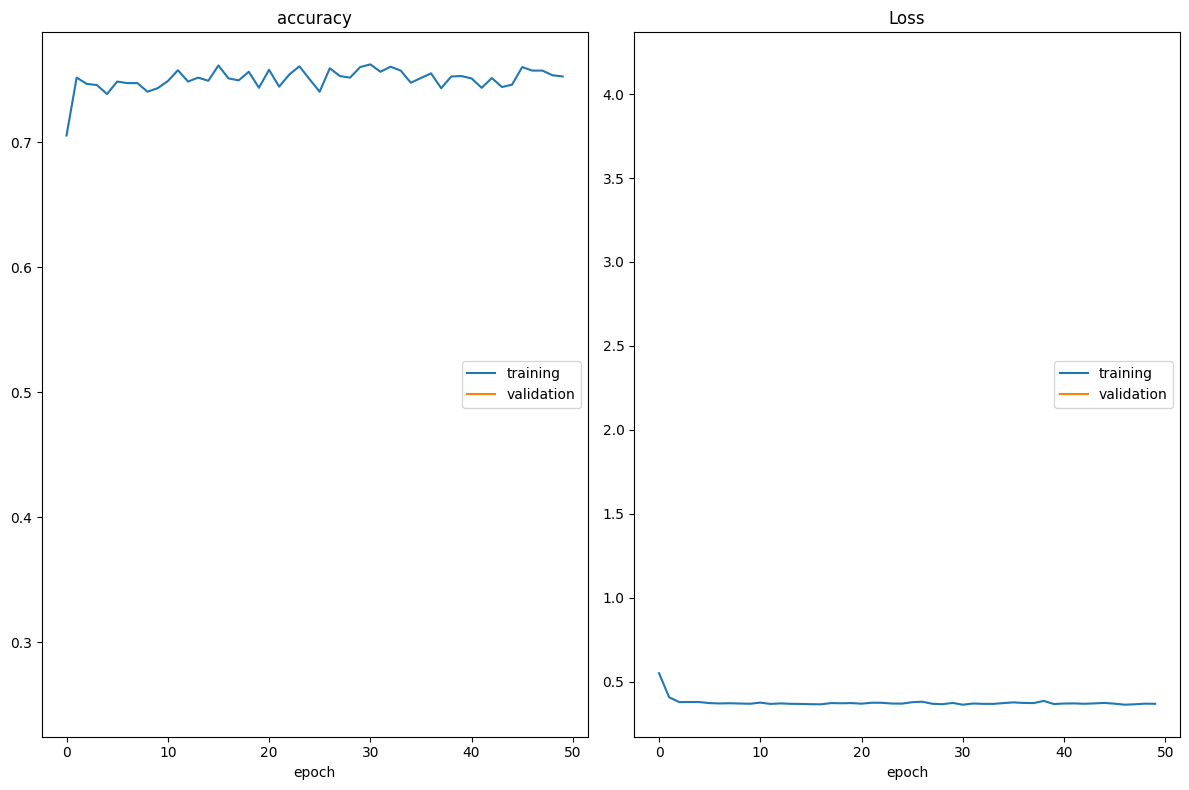

accuracy
	training         	 (min:    0.705, max:    0.762, cur:    0.752)
	validation       	 (min:    0.250, max:    0.250, cur:    0.250)
Loss
	training         	 (min:    0.364, max:    0.551, cur:    0.369)
	validation       	 (min:    4.177, max:    4.177, cur:    4.177)
100/100 [==============================] - 4s 42ms/step - loss: 0.3688 - accuracy: 0.7525


In [37]:
history=model.fit(
    datagen_train.flow(x_train,y_train,batch_size=32,shuffle=True),
    steps_per_epoch = len(x_train) // 32,
    validation_data=datagen_train.flow(x_val,y_labels,batch_size=32,shuffle=True),
    validation_steps=len(x_train )// 32,
    epochs=50,
    callbacks=callbacks
)

In [38]:
 model.evaluate(x_val,y_labels)

25/25 [==============================] - 0s 8ms/step - loss: 0.3722 - accuracy: 0.7400


[0.3722037971019745, 0.7400000095367432]

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_labels, 1)
y_pred = np.argmax(model.predict(x_val), 1)

print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

25/25 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       200
           1       0.00      0.00      0.00       200
           2       0.49      0.98      0.66       200
           3       1.00      1.00      1.00       200

    accuracy                           0.74       800
   macro avg       0.62      0.74      0.66       800
weighted avg       0.62      0.74      0.66       800

Classification accuracy: 0.740000


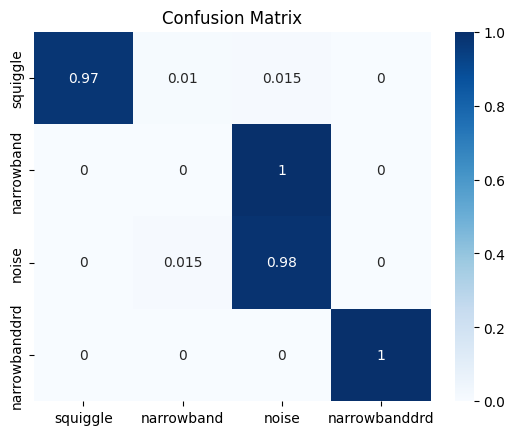

In [40]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues);
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);